# Installing libraries

In [ ]:
!pip install PEPit

In [ ]:
!pip install Mosek

In [3]:
from PEPit import PEP
from PEPit.functions import SmoothConvexFunction, SmoothStronglyConvexFunction
from PEPit.primitive_steps import inexact_gradient_step
from PEPit.point import Point
import mosek

In [4]:
import cvxpy as cp

print(cp.installed_solvers())

['ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


If solver MOSEK is not available one can use SCS solver instead

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import re
from numpy.linalg import norm
from math import floor
from tqdm import tqdm  
from itertools import product
from sklearn.model_selection import train_test_split 

In [6]:
#graphs settings
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15

# CODE

In [7]:
#Obtain inexact gradient with both relative and absolute setup
def inexact_grad(x, f, epsilon, notion = 'relative'):
    exact_grad_x = f.gradient(x)
    inexact_grad_x = Point()
    if epsilon != 0.:
        if notion == 'absolute':
            f.add_constraint((exact_grad_x - inexact_grad_x) ** 2 - epsilon ** 2 <= 0)
        elif notion == 'relative':
            f.add_constraint((exact_grad_x - inexact_grad_x) ** 2 - epsilon ** 2 * (exact_grad_x ** 2) <= 0)
        else:
            raise ValueError("inexact_gradient_step supports only notion in ['absolute', 'relative'],"
                            " got {}".format(notion))
        return inexact_grad_x, exact_grad_x
    else:
        return exact_grad_x, exact_grad_x

In [8]:
#Implementation of ISTM algorithm on whole R^2 
def ISTM(f, N, x_0, L, a = None, epsilon = 0., p = 2, notion = 'relative'):
    
    if a is None:
        a = 2       
    x_k = x_0
    alpha_k = 0
    A_k = 0
    y_k = x_k
    z_k = x_k
    
    for k in range(N):
        alpha_k_plus_1  = (k + 2) ** (p - 1) / (2 * a * L)
        A_k_plus_1 = alpha_k_plus_1 + A_k
        
        x_k_plus_1 = 1/A_k_plus_1 * (A_k * y_k + alpha_k_plus_1 * z_k)
        inexact_grad_x, exact_grad_x = inexact_grad(x_k_plus_1 , f, epsilon, notion = notion )
        z_k_plus_1 = z_k - alpha_k_plus_1 * inexact_grad_x
        y_k_plus_1 = 1 / A_k_plus_1 * (A_k * y_k + alpha_k_plus_1 * z_k_plus_1)
        
        y_k = y_k_plus_1
        z_k = z_k_plus_1
        x_k = x_k_plus_1
        A_k = A_k_plus_1
        alpha_k = alpha_k_plus_1
        
    return y_k

In [9]:
def solve_problem( N, epsilon, p, a = None, L = 1, mu = None, problem_algo = ISTM, verbose = 0, notion = 'relative', solver = 'MOSEK'):
    problem = PEP()

    # Declare a (strongly) convex smooth function
    if mu is None or mu == 0:
        func = problem.declare_function(SmoothConvexFunction, L = L)
    else:
        func = problem.declare_function(SmoothStronglyConvexFunction, L = L, mu = mu)

    # Start by defining its unique optimal point xs = x_* and corresponding function value fs = f_*
    x_s = func.stationary_point()
    f_s = func(x_s)

    # Then define the starting point x0 of the algorithm
    # as well as corresponding inexact gradient and function value g0 and f0
    x_0 = problem.set_initial_point()

    # Set the initial constraint that is the distance between f0 and f_*
    
    problem.set_initial_condition((x_0 - x_s) ** 2 <= 1)
    #calculate iterations of intermediate_Gradient 


    y_N = problem_algo(func, N, x_0, L = L, a = a, epsilon = epsilon, p = p, notion = notion)

    problem.set_performance_metric(func(y_N) - f_s)

    #Solve optimization problem

    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose = pepit_verbose, solver = solver)
    return pepit_tau

In [10]:
# run iter_num of iterations of algorithm and return list of pepit_taus 
def run_iterations(iter_num, epsilon, p = 2, a_s = None, L = 1, mu = None, problem_algo = ISTM, verbose = 0, notion = 'relative', solver = 'MOSEK'):
    pepit_taus = []
    if verbose == 0:
        internal_range = range(iter_num + 1)
    else:
        internal_range = tqdm(range(iter_num + 1)) 
    if a_s is None:
        a_s = [None] * (iter_num + 1)
        
    for i, N in enumerate(internal_range):
        pepit_taus.append(solve_problem(N = N, epsilon = epsilon, a = a_s[i], L = L, mu = mu, p = p, problem_algo = problem_algo, verbose = verbose, notion = notion, solver = solver))
    
    return pepit_taus

# Experiment

For a more detailed description of the experimental conditions, we refer the reader to the original article

## STM N disconvergence (Extra Exp 1)

In [36]:
first_exp_data_dict = dict()

In [37]:
a_range = list(range(2,30,3))
eps_range = [0.65, 0.8, 0.90]
p = 2
mu = 0
L  = 1
iter_num = 30

for eps in tqdm(eps_range):
    a_dict = dict()
    for a in a_range:
        pepit_taus = run_iterations(iter_num, a_s = [a] * (iter_num + 1), epsilon = eps, L = L, mu = mu, p = p)
        a_dict[a] = pepit_taus
    first_exp_data_dict[eps] = a_dict 

100%|██████████| 3/3 [14:59<00:00, 299.73s/it]


In [38]:
import pickle 

with open('STM_data_dict.pkl', 'wb') as f:
        pickle.dump(first_exp_data_dict, f)

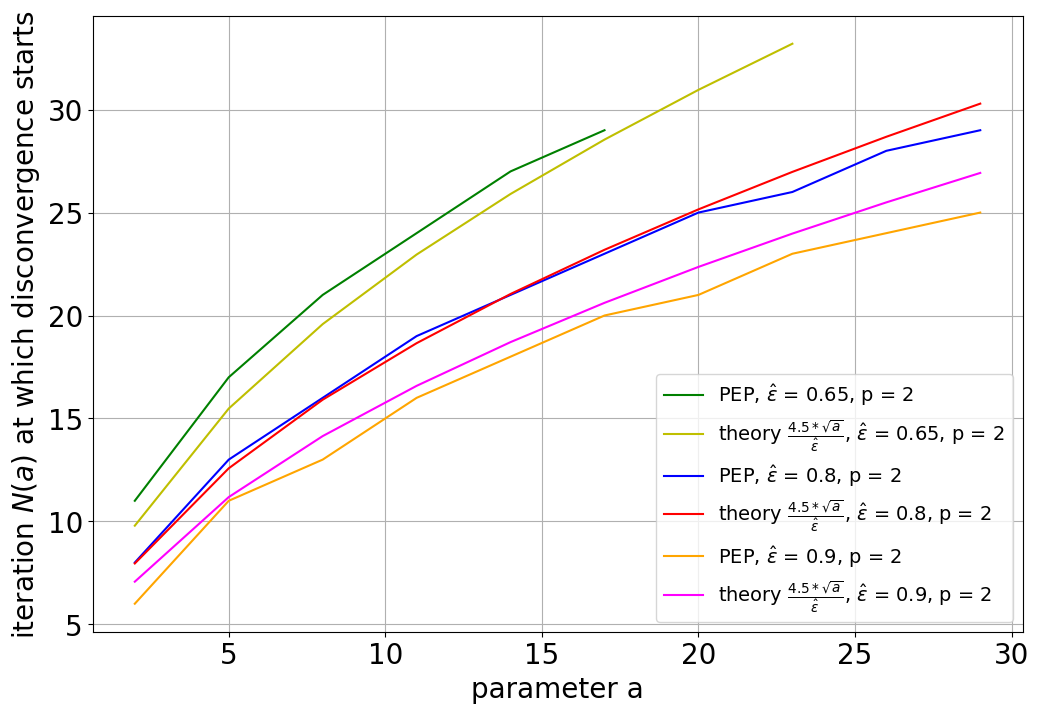

In [39]:
plt.figure(figsize = (12,8))
p = 2
a_range = range(2,30,3)
colors = ['g', 'y', 'b', 'r', 'orange', 'magenta']
i = 0

for eps in eps_range:
    
    N_pep_s = []
    for a in a_range:
        N_pep = np.argmin(first_exp_data_dict[eps][a])
        if N_pep < iter_num :
            N_pep_s.append(N_pep)
    theory = [(4.5**2 *a/eps**2)**(1/p) for a in a_range if (4.5**2 *a/eps**2)**(1/p) < iter_num + 5]
    
    plt.plot(a_range[:len(N_pep_s)], N_pep_s, color = colors[i], label = 'PEP, $\\hat{\\varepsilon}$ = ' + str(np.round(eps, 2)) + f', p = {p}')
    i += 1
    
    plt.plot(a_range[:len(theory)], theory, color = colors[i], label = 'theory $\\frac{4.5* \\sqrt{a}}{\\hat{\\varepsilon}}$, $\\hat{\\varepsilon}$ = ' + str(np.round(eps, 2)) + f', p = {p}')
    i += 1

plt.xlabel('parameter a', fontsize = 20)
plt.ylabel('iteration $N(a)$ at which disconvergence starts', fontsize = 20)
plt.legend()
plt.grid()
#plt.savefig('STM_N_disconvergence.pdf')

## STM Convergence (Extra Exp 2)

In [16]:
second_exp_data_dict = dict()

In [17]:
eps_range = np.linspace(0.1, 0.95, 7)
p = 2
mu = 0
L  = 1
iter_num = 50

for eps in tqdm(eps_range):
        a_s = [max(1, N**p * eps**2, N**(p / 2) * eps, N**(p / 4) * eps**0.5) for N in range(iter_num + 1)]
        pepit_taus = run_iterations(iter_num, a_s = a_s, epsilon = eps, L = L, mu = mu, p = p)
        second_exp_data_dict[eps] = pepit_taus 

100%|██████████| 7/7 [30:14<00:00, 259.24s/it]


In [18]:
import pickle 

with open('STM_convergence_dict.pkl', 'wb') as f:
        pickle.dump(second_exp_data_dict, f) 

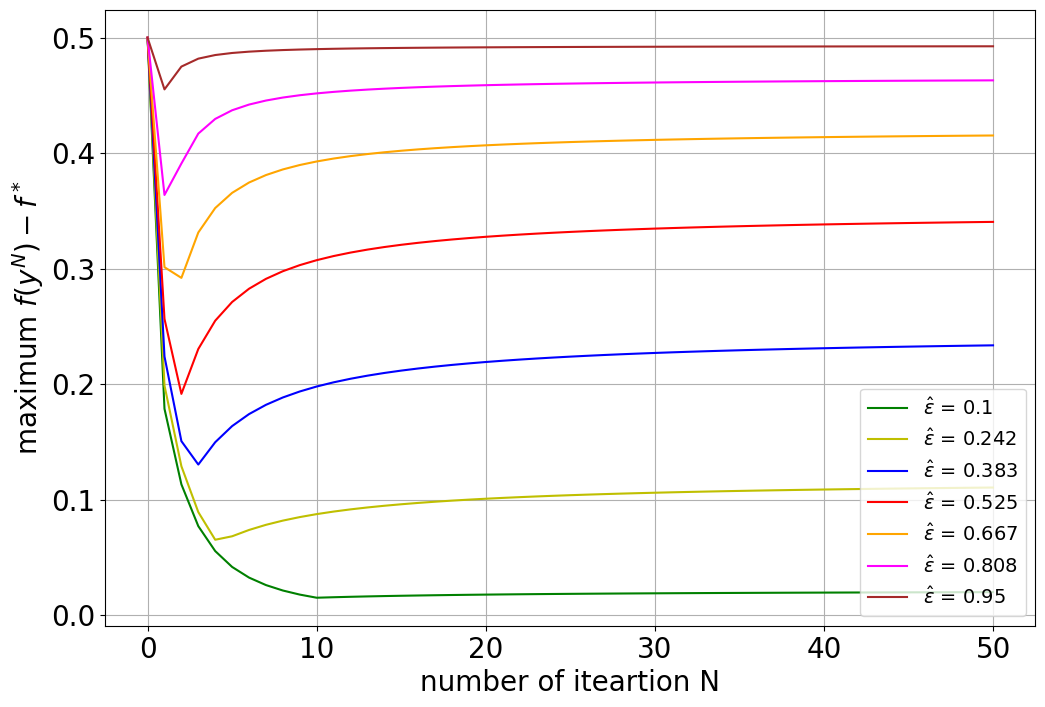

In [19]:
plt.figure(figsize = (12,8))

colors = ['g', 'y', 'b', 'r', 'orange', 'magenta', 'brown']
i = 0
iter_num = 50
eps_range = np.linspace(0.1, 0.95, 7)

for eps in eps_range:
    plt.plot(range(iter_num + 1), second_exp_data_dict[eps], color = colors[i], label = '$\\hat{\\varepsilon}$ = ' + f'{np.round(eps, 3)}')
    i += 1
plt.xlabel('number of iteartion N', fontsize = 20)
plt.ylabel('maximum $f(y^N) - f^*$', fontsize = 20)
plt.legend()
plt.grid()
#plt.savefig('STM_Convergence.pdf')

Error: 0.08707402202230495
Coef [ 0.58125345 -0.00871321]


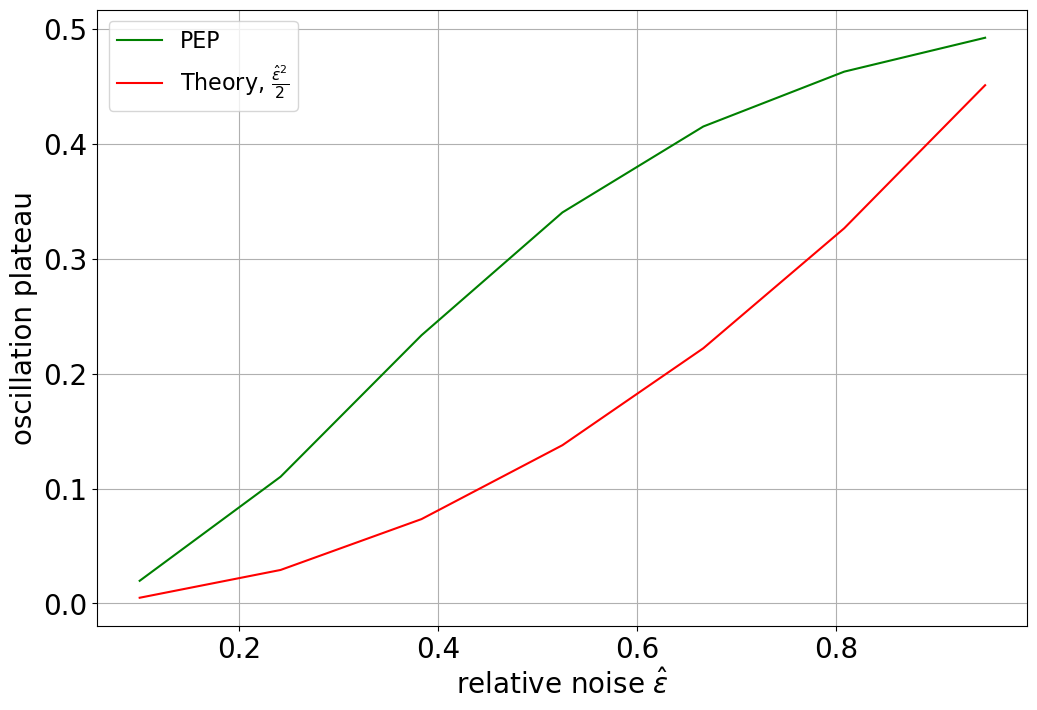

In [20]:
plt.figure(figsize = (12,8))

eps_range = np.linspace(0.1, 0.95, 7)
platos = [second_exp_data_dict[eps][-1] for eps in eps_range]
theory  = [0.5 * eps**2 for eps in eps_range]

plt.plot(eps_range, platos, label = 'PEP', color = 'g')
plt.plot(eps_range, theory, label = 'Theory, $\\frac{\\hat{\\varepsilon}^2}{2}$', color = 'r')
plt.xlabel('relative noise $\\hat{\\varepsilon}$', fontsize = 20)
plt.ylabel('oscillation plateau', fontsize = 20)
plt.legend(prop = {'size' : 16})
plt.grid()
#plt.savefig('STM_plateau.pdf')
p = np.polyfit(x = eps_range , y = platos, deg = 1)
error = np.linalg.norm(np.polyval(p, eps_range) - platos)
print(f'Error: {error}')
print('Coef', p)

$$f = \frac12 \varepsilon^2 LR^2$$

## ISTM N disconvergence (Exp 1)

In [32]:
third_exp_data_dict = dict()

In [33]:
a_range = np.linspace(1.5,15,10)
p_range = [1.5, 1.75, 2]

mu = 0
L  = 1
eps = 0.75
iter_num = 30

for p in tqdm(p_range):
    a_dict = dict()
    for a in a_range:
        pepit_taus = run_iterations(iter_num, a_s = [a] * (iter_num + 1), epsilon = eps, L = L, mu = mu, p = p)

        a_dict[a] = pepit_taus
    third_exp_data_dict[p] = a_dict

100%|██████████| 3/3 [15:08<00:00, 302.70s/it]


In [34]:
import pickle 

with open('ISTM_eps_75_data_dict.pkl', 'wb') as f:
        pickle.dump(third_exp_data_dict, f)

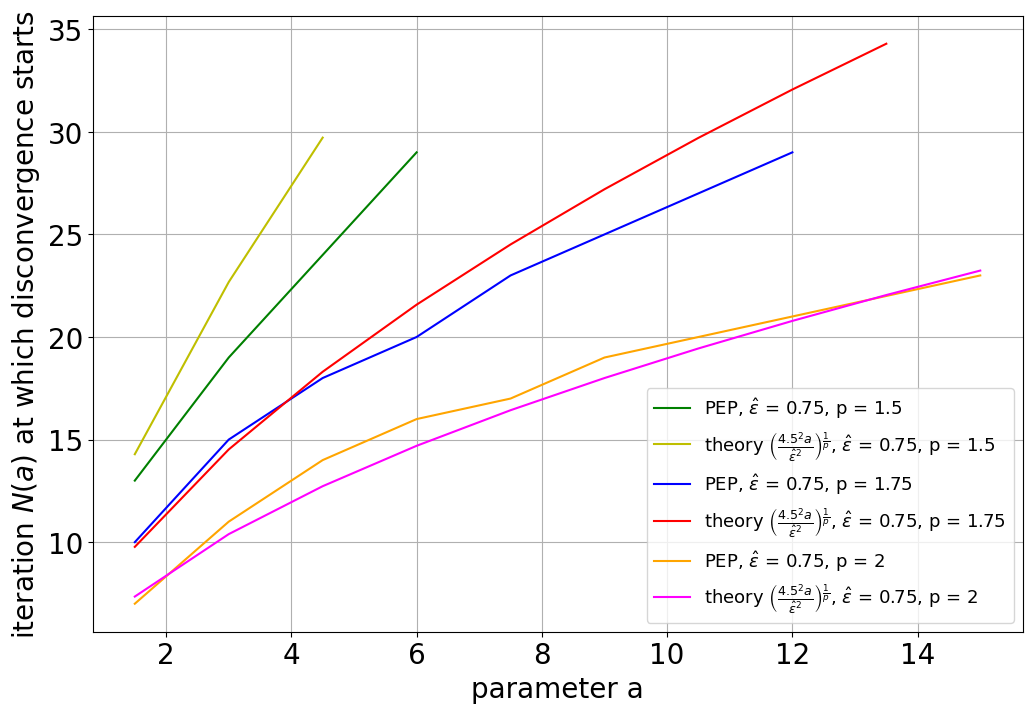

In [35]:
plt.figure(figsize = (12,8))
eps = 0.75
a_range = np.linspace(1.5,15,10)
colors = ['g', 'y', 'b', 'r', 'orange', 'magenta']
i = 0

for p in p_range:
    N_pep_s = []
    for a in a_range:
        N_pep = np.argmin(third_exp_data_dict[p][a]) 
        if N_pep < iter_num:
            N_pep_s.append(N_pep)
    theory = [(4.5**2 *a/eps**2)**(1/p) for a in a_range if (4.5**2 *a/eps**2)**(1/p) <= iter_num + 5]
    
    plt.plot(a_range[:len(N_pep_s)], N_pep_s, color = colors[i], label = 'PEP, $\\hat{\\varepsilon}$ = ' + str(np.round(eps, 2)) + f', p = {p}')
    i += 1
    plt.plot(a_range[:len(theory)], theory, color = colors[i], label = 'theory $\\left(\\frac{4.5^2 a}{\\hat{\\varepsilon}^2} \\right)^\\frac{1}{p}$, $\\hat{\\varepsilon}$ = ' + str(np.round(eps, 2)) + f', p = {p}')
    i += 1
    
plt.xlabel('parameter a', fontsize = 20)
plt.ylabel('iteration $N(a)$ at which disconvergence starts', fontsize = 20)
plt.legend(prop={'size': 13})
plt.grid()
#plt.savefig('ISTM_N_disconvergence.pdf')


0*
## ISTM Convergence (Exp 2)

In [25]:
forth_exp_data_dict = dict()

In [26]:
p_range = [1, 1.25, 1.5, 1.75, 2]

mu = 0
L  = 1
iter_num = 50
eps = 0.95

for p in tqdm(p_range):
    
        a_s = [max(1, N**p * eps**2, N**(p / 2) * eps, N**(p / 4) * eps**0.5) for N in range(iter_num + 1)]
        pepit_taus = run_iterations(iter_num, a_s = a_s, epsilon = eps, L = L, mu = mu, p = p)
        forth_exp_data_dict[p] = pepit_taus 

100%|██████████| 5/5 [22:08<00:00, 265.64s/it]


In [27]:
import pickle 

with open('ISTM_convergence_dict.pkl', 'wb') as f:
        pickle.dump(forth_exp_data_dict, f)

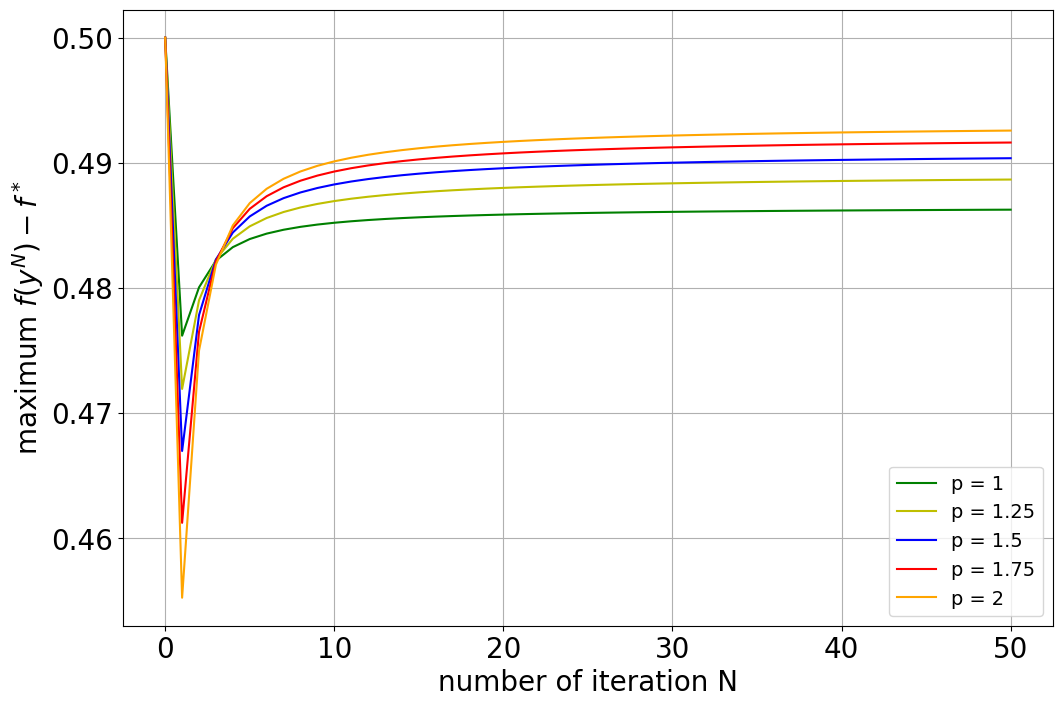

In [28]:
plt.figure(figsize = (12,8))

colors = ['g', 'y', 'b', 'r', 'orange', 'magenta', 'brown']
i = 0

for p in p_range:
    plt.plot(range(iter_num + 1), forth_exp_data_dict[p], color = colors[i], label = f'p = {p}')
    i += 1

plt.xlabel('number of iteration N', fontsize =20)
plt.ylabel('maximum $f(y^N) - f^*$', fontsize = 20)
plt.legend()
plt.grid()
#plt.savefig('ISTM_Convergence.pdf')